### Semantic Analysis

In [10]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

from google import genai
from google.genai.types import EmbedContentConfig

from scipy.spatial import ConvexHull

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import re
from tqdm import tqdm



In [11]:
def remove_exact_emotion(text: str, emotion: str) -> str:
    """
    Remove only the exact emotion word (case-insensitive) from text,
    leaving words like 'joyful' or 'enjoy' intact.
    """
    if pd.isna(text) or not text:
        return ''
    pattern = re.compile(rf'\b{re.escape(emotion)}\b', flags=re.IGNORECASE)
    cleaned = pattern.sub('', text)
    return re.sub(r'\s+', ' ', cleaned).strip()


In [12]:
llm_df = pd.read_csv("../output/llm_df.csv")

# 1. Init Vertex-backed GenAI client
client = genai.Client(
    vertexai=True,
    project="emotion-art-analysis",
    location="us-central1",
)


# 3. Embed one at a time (batchSize must be 1)
embeddings = []
for emotion, text in tqdm(zip(llm_df['Emotion'], llm_df['emo_explanation']), total=len(llm_df), desc="Embedding cleaned explanations"):
    cleaned_text = remove_exact_emotion(text, emotion)
    resp = client.models.embed_content(
        model="gemini-embedding-001",
        contents=[cleaned_text],  
        config=EmbedContentConfig(
            task_type="CLUSTERING",

        ),
    )
    # grab the single embedding vector
    embeddings.append(resp.embeddings[0].values)

# 4. Attach embeddings and save
llm_df['embedding'] = embeddings


llm_df.to_parquet('../output/llm__embeddings.parquet', index=False)

print("✓ All explanations embedded and saved to llm__embeddings.parquet")

Embedding cleaned explanations: 100%|██████████| 6076/6076 [16:47<00:00,  6.03it/s]  


✓ All explanations embedded and saved to llm_df_with_embeddings.parquet


In [20]:
#import dataset

embeddings_df = pd.read_parquet('../output/llm__embeddings.parquet')
embeddings = np.array(embeddings_df['embedding'].tolist())



In [22]:
embeddings_df['clean_explanation'] = llm_df.apply(
    lambda row: remove_exact_emotion(row['emo_explanation'], row['Emotion']),
    axis=1
)

In [24]:
embeddings_df['clean_explanation'][0]

'There is absolutely nothing in this painting that elicits a feeling of . The artwork presents a serene and aesthetically pleasing scene: a woman is peacefully seated in a vibrant, sunlit garden. Her attire is elegant, and her expression appears contemplative or observational, devoid of any hint of revulsion, unease, or physical sickness. The environment is meticulously rendered with bright, harmonious colors, depicting lush greenery, well-maintained paths, and healthy plants. There are no elements of decay, squalor, grotesque imagery, unpleasant textures, or any visual cues typically associated with the emotion of . The overall impression is one of tranquility, beauty, and quiet contemplation, which stands in complete opposition to any sensation of .'

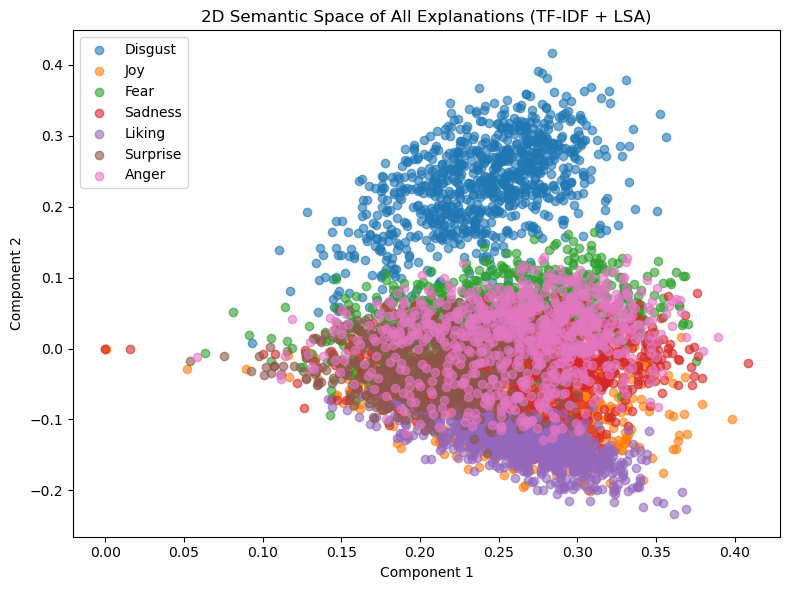

In [28]:
#Latent Semantic Analysis
# 1. Load the data
texts = embeddings_df['clean_explanation'].fillna('').tolist()
emotions = embeddings_df['Emotion'].tolist()

# 2. Vectorize all explanations with TF-IDF
mixed_vectorizer = TfidfVectorizer(stop_words='english')
mixed_X = mixed_vectorizer.fit_transform(texts)

# 3. Reduce to 2D via Truncated SVD (LSA)
svd = TruncatedSVD(n_components=2, random_state=0)
mixed_X2 = svd.fit_transform(mixed_X)

# 4. Plot the semantic space
plt.figure(figsize=(8,6))
unique_emotions = list(dict.fromkeys(emotions))  # preserve order
for emo in unique_emotions:
    mask = np.array(emotions) == emo
    plt.scatter(mixed_X2[mask, 0], mixed_X2[mask, 1], label=emo, alpha=0.6)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Semantic Space of All Explanations (TF-IDF + LSA)')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
terms = mixed_vectorizer.get_feature_names_out()
for i, comp in enumerate(svd.components_):
    top_idx = np.argsort(comp)[-10:]
    print(f"Component {i+1} top terms:", terms[top_idx])

Component 1 top terms: ['colors' 'feeling' 'composition' 'elements' 'abstract' 'forms' 'color'
 'painting' 'visual' 'sense']
Component 2 top terms: ['fluids' 'morally' 'bodily' 'trigger' 'filth' 'offensive' 'grotesque'
 'revulsion' 'decay' 'repulsive']


In [30]:
import plotly.express as px
svd3 = TruncatedSVD(n_components=3, random_state=0)
X3 = svd3.fit_transform(X)

PCA3_df = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
PCA3_df['Emotion'] = embeddings_df['Emotion'].values
fig = px.scatter_3d(PCA3_df, x='PC1', y='PC2', z='PC3', color='Emotion')
fig.show()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1,3)
)
X = vectorizer.fit_transform(embeddings_df['clean_explanation'].fillna(''))


In [32]:

summaries = []
for emo in llm_df['Emotion'].unique():
    mask = llm_df['Emotion'] == emo
    coords = X2[mask]  # or X2_umap
    centroid = coords.mean(axis=0)
    hull = ConvexHull(coords)
    summaries.append({
        'Emotion': emo,
        'Centroid_X': centroid[0],
        'Centroid_Y': centroid[1],
        'Hull_Area': hull.volume
    })
summary_df = pd.DataFrame(summaries)

In [33]:
summary_df

,Emotion,Centroid_X,Centroid_Y,Hull_Area
0,Disgust,0.238774,0.227731,0.064845
1,Joy,0.260305,-0.083447,0.054138
2,Fear,0.251038,0.039994,0.060119
3,Sadness,0.265914,-0.032882,0.057829
4,Liking,0.267058,-0.134828,0.022721
5,Surprise,0.212937,-0.017522,0.038241
6,Anger,0.264665,0.014892,0.055954


### Embeddings Clustering (k-means)

In [34]:
# Force single-threaded BLAS (avoids threadpool errors)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]     = "1"
os.environ["MKL_NUM_THREADS"]     = "1"

# Silhouette analysis to pick k (clusters = 2…8)
sil_scores = {}
for k in range(2, 9):
    clust = AgglomerativeClustering(n_clusters=k)
    labels = clust.fit_predict(embeddings)
    sil_scores[k] = silhouette_score(embeddings, labels)

print("Silhouette scores:", sil_scores)

# 4. Choose best k and fit final clustering
best_k = max(sil_scores, key=sil_scores.get)
print(f"→ Best k by silhouette: {best_k}")
embeddings_df['cluster'] = AgglomerativeClustering(n_clusters=best_k).fit_predict(embeddings)



Silhouette scores: {2: 0.23336561004924525, 3: 0.10481469079005287, 4: 0.11859086898333637, 5: 0.111394045398454, 6: 0.10719539643101535, 7: 0.10068472758318467, 8: 0.09231046592053842}
→ Best k by silhouette: 2


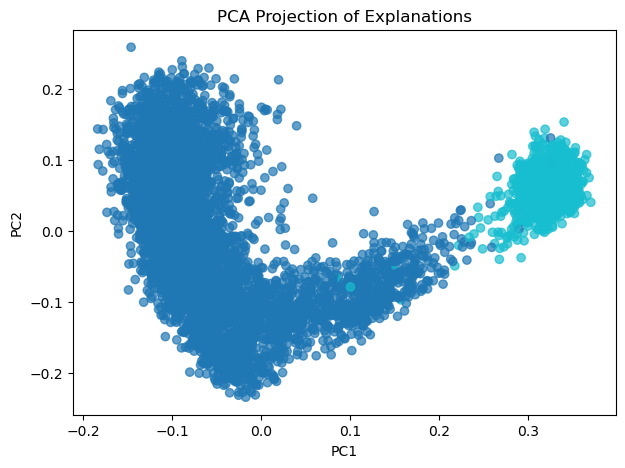

In [36]:
pca = PCA(n_components=2, random_state=0)
proj_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(7,5))
plt.scatter(proj_pca[:,0], proj_pca[:,1], c=embeddings_df['cluster'], cmap='tab10', alpha=0.7)
plt.title("PCA Projection of Explanations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [37]:
ct = pd.crosstab(embeddings_df['cluster'], embeddings_df['Emotion'])
print("Emotion distribution per cluster:")
print(ct)
print()

Emotion distribution per cluster:
Emotion  Anger  Disgust  Fear  Joy  Liking  Sadness  Surprise
cluster                                                      
0          868      868   868  868       4      868       867
1            0        0     0    0     864        0         1



/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_74482/3837227124.py:15: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



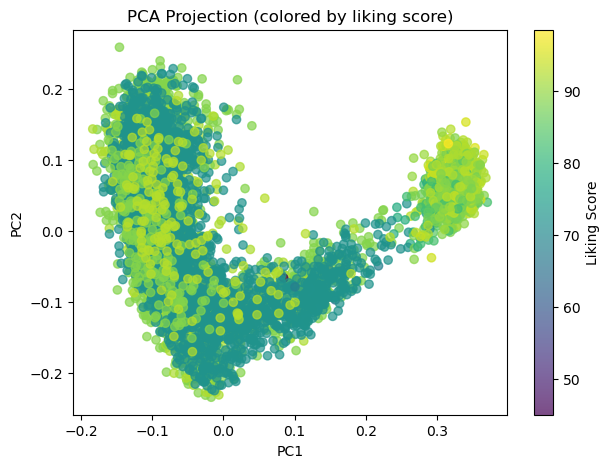

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.manifold import SpectralEmbedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load data
emb = np.array(embeddings_df['embedding'].tolist())
liking_scores = embeddings_df['emo_rating'].where(embeddings_df['Emotion']=='Liking', np.nan).fillna(method='ffill').fillna(method='bfill')

# 1. PCA projection colored by liking score
pca = PCA(n_components=2, random_state=0)
proj_pca = pca.fit_transform(emb)
plt.figure(figsize=(7,5))
sc = plt.scatter(proj_pca[:,0], proj_pca[:,1], c=liking_scores, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Liking Score')
plt.title("PCA Projection (colored by liking score)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


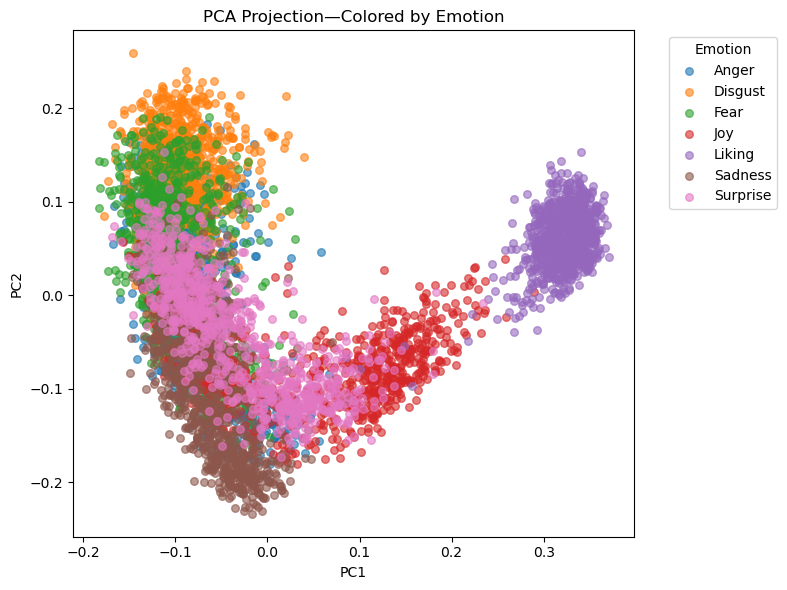

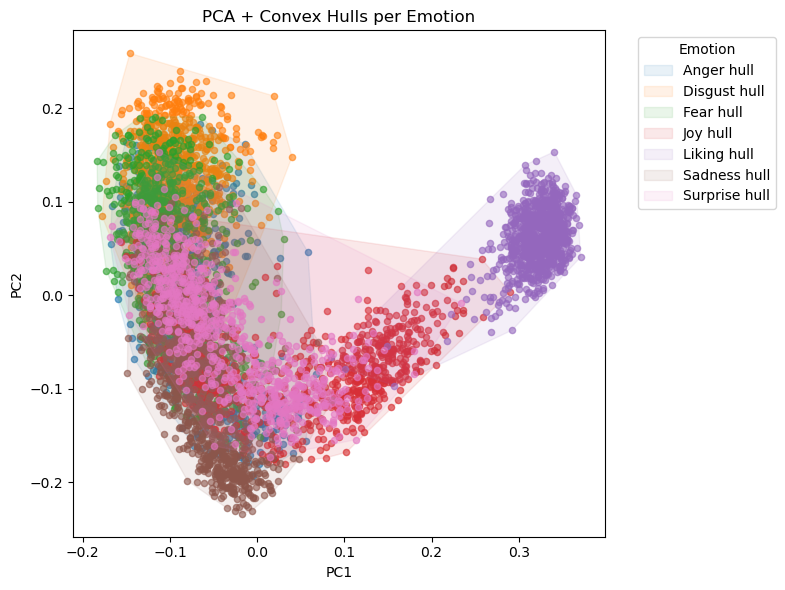

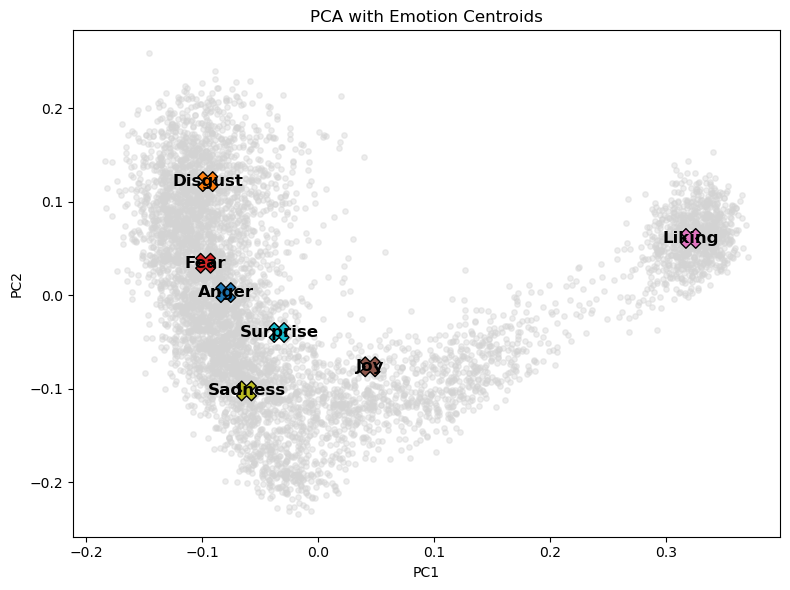

In [43]:
# 2. Compute PCA projection
pca = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(emb)
embeddings_df['PC1'], embeddings_df['PC2'] = proj[:,0], proj[:,1]

# 3. Basic scatter colored by emotion
plt.figure(figsize=(8,6))
for emo, subset in embeddings_df.groupby('Emotion'):
    plt.scatter(
        subset['PC1'], subset['PC2'],
        label=emo, alpha=0.6, s=30
    )
plt.legend(bbox_to_anchor=(1.05,1), title="Emotion")
plt.title("PCA Projection—Colored by Emotion")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


# 4. Plot convex hull around each emotion’s cloud
plt.figure(figsize=(8,6))
colors = plt.cm.tab10.colors
for (i, (emo, subset)) in enumerate(embeddings_df.groupby('Emotion')):
    pts = subset[['PC1','PC2']].values
    if len(pts) >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        plt.fill(
            hull_pts[:,0], hull_pts[:,1],
            alpha=0.1, color=colors[i], label=f"{emo} hull"
        )
    plt.scatter(
        pts[:,0], pts[:,1],
        color=colors[i], alpha=0.6, s=20, label=None
    )
plt.legend(bbox_to_anchor=(1.05,1), title="Emotion")
plt.title("PCA + Convex Hulls per Emotion")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


# 5. Compute & plot emotion centroids
centroids = embeddings_df.groupby('Emotion')[['PC1','PC2']].mean()
plt.figure(figsize=(8,6))
plt.scatter(embeddings_df['PC1'], embeddings_df['PC2'], c='lightgray', alpha=0.4, s=15)
plt.scatter(
    centroids['PC1'], centroids['PC2'],
    c=range(len(centroids)), cmap='tab10',
    s=200, marker='X', edgecolor='k'
)
for emo, (x,y) in centroids.iterrows():
    plt.text(x, y, emo, fontsize=12, weight='bold',
             ha='center', va='center')
plt.title("PCA with Emotion Centroids")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

Explained variance ratio (first 10 PCs):
  PC1: 0.1690
  PC2: 0.1024
  PC3: 0.0735
  PC4: 0.0593
  PC5: 0.0524
  PC6: 0.0463
  PC7: 0.0388
  PC8: 0.0357
  PC9: 0.0281
  PC10: 0.0226

Total variance captured by PC1+PC2: 0.2713  (27.1%)


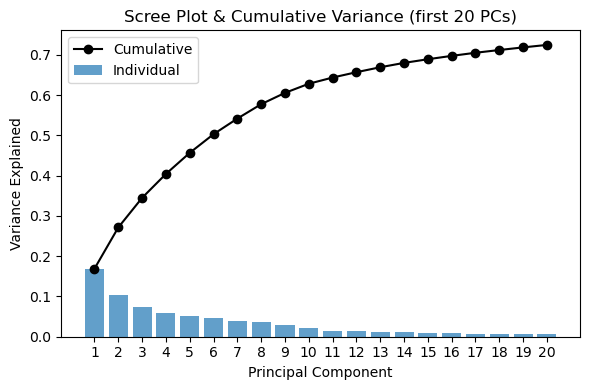

In [23]:
from sklearn.decomposition import PCA
import numpy as np

# assume `embeddings` is your (n_samples × 3072) array
pca = PCA(n_components=3072, random_state=0)  
pca.fit(embeddings)

# variance explained by each component
var_ratio = pca.explained_variance_ratio_

print("Explained variance ratio (first 10 PCs):")
for i, v in enumerate(var_ratio[:10], start=1):
    print(f"  PC{i}: {v:.4f}")

# total variance captured by the first two PCs
cum2 = var_ratio[:2].sum()
print(f"\nTotal variance captured by PC1+PC2: {cum2:.4f}  ({cum2*100:.1f}%)")

# (Optional) Scree plot of the first 20 components:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(np.arange(1,21), var_ratio[:20], alpha=0.7)
plt.plot(np.arange(1,21), np.cumsum(var_ratio[:20]), marker='o', color='k')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot & Cumulative Variance (first 20 PCs)")
plt.xticks(range(1,21))
plt.legend(["Cumulative", "Individual"])
plt.tight_layout()
plt.show()


/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_74482/1156928101.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




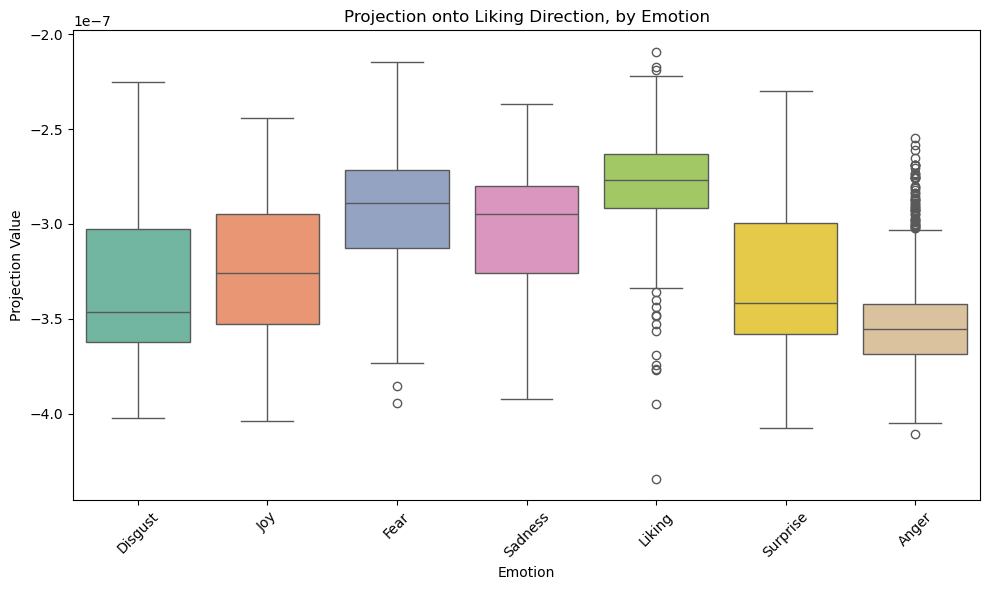

/var/folders/fk/gj43ql8172g1p_322ps4bc440000gn/T/ipykernel_74482/1156928101.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




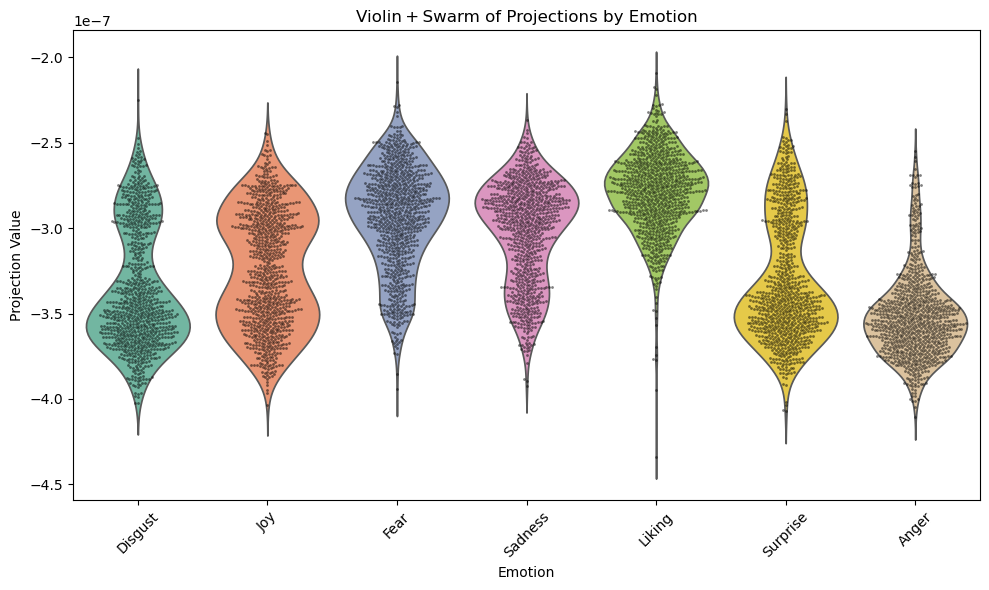

Projection onto Liking Direction — by Emotion:

          count          mean           std
Emotion                                    
Anger       868 -3.517398e-07  2.498735e-08
Disgust     868 -3.352013e-07  3.557730e-08
Fear        868 -2.939290e-07  3.033067e-08
Joy         868 -3.240521e-07  3.418653e-08
Liking      868 -2.787734e-07  2.403632e-08
Sadness     868 -3.021043e-07  2.993672e-08
Surprise    868 -3.305855e-07  3.587784e-08


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. Compute liking direction & projections (as before)
mask_like   = ~np.isnan(liking_scores)
X_reg       = emb[mask_like]
y_reg       = liking_scores[mask_like]
reg         = LinearRegression().fit(X_reg, y_reg)
direction   = reg.coef_ / np.linalg.norm(reg.coef_)
proj_like   = emb.dot(direction)

# 2. Merge into a DataFrame
df_proj = embeddings_df.copy()
df_proj['proj_like'] = proj_like

# 3. Boxplot of projection by Emotion
plt.figure(figsize=(10,6))
sns.boxplot(
    x='Emotion', 
    y='proj_like', 
    data=df_proj, 
    palette='Set2'
)
plt.xticks(rotation=45)
plt.title("Projection onto Liking Direction, by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Projection Value")
plt.tight_layout()
plt.show()

# 4. (Optional) Violin + swarm for more detail
plt.figure(figsize=(10,6))
sns.violinplot(
    x='Emotion', 
    y='proj_like', 
    data=df_proj, 
    inner=None, 
    palette='Set2'
)
sns.swarmplot(
    x='Emotion', 
    y='proj_like', 
    data=df_proj, 
    color='k', 
    size=2, 
    alpha=0.5
)
plt.xticks(rotation=45)
plt.title("Violin + Swarm of Projections by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Projection Value")
plt.tight_layout()
plt.show()

# 5. Summary statistics
stats = df_proj.groupby('Emotion')['proj_like'].agg(['count','mean','std'])
print("Projection onto Liking Direction — by Emotion:\n")
print(stats)


In [42]:

# 4. Contingency: DBSCAN cluster vs. original emotion
ct = pd.crosstab(embeddings_df['dbscan_cluster'], embeddings_df['Emotion'])
print("Contingency table (DBSCAN cluster x Emotion):")
print(ct)

# 5. Joint LDA across all explanations: average liking per topic
texts = embeddings_df['clean_explanation'].fillna('').tolist()
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
dtm = vectorizer.fit_transform(texts)
lda = LatentDirichletAllocation(n_components=5, random_state=0)
topic_dist = lda.fit_transform(dtm)  # n_samples × n_topics
df_topics = pd.DataFrame(topic_dist, columns=[f"Topic{i+1}" for i in range(topic_dist.shape[1])])
df_topics['liking_score'] = liking_scores.values

# Average liking per topic
corrs = df_topics.corr()['liking_score'].drop('liking_score')
print("Correlation with liking by topic:")
print(corrs)



KeyError: 'dbscan_cluster'